# **Project Title**: Transforming Natural Language into SQL Queries Using NLP and Machine Learning

 # Project Members:
**1.Vendant patel**

**2.Meher Venkat**

**3.Venkata Sainath Rameswarapu**

# **Introduction**

Accessing and analyzing data stored in databases is an important task, but writing SQL queries can be difficult for people who are not familiar with programming or query languages. This project aims to make database interaction easier by using advanced natural language processing (NLP) models to convert everyday language into SQL queries. This allows users to ask questions or give instructions in plain language and get the correct database results without needing to know SQL.

We explored and fine-tuned several powerful NLP models, including T5, BART, BERT, and a Helsinki NLP. Each model brings unique strengths to the task of generating SQL queries, from handling simple instructions to producing complex queries with joins, aggregations, and nested conditions. By combining and comparing these models, we aim to find the best approach for accurate and efficient query generation.

**Our project focuses on achieving:**

High accuracy in matching generated SQL with the correct queries.

Robust performance for handling complex query types like joins.

A user-friendly solution that works well across diverse database schemas.


# Setup and Imports

In [ ]:
# importing all the necessary libraries required -Meher
import json
import torch
import warnings
import pandas as pd, numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
import random
from torch import nn
from torch.utils.data import Dataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, RocCurveDisplay
warnings.filterwarnings('ignore')

from transformers import (
    T5Tokenizer, T5ForConditionalGeneration,
    BartTokenizer, BartForConditionalGeneration,
    BertTokenizer, BertLMHeadModel,
    AutoTokenizer, AutoModelForSeq2SeqLM,
    Trainer, TrainingArguments, Seq2SeqTrainer, Seq2SeqTrainingArguments
)

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

def load(path):
    with open(path, 'r') as f:
        return json.load(f)


pd.set_option('display.max_rows', None)
sns.set(style='whitegrid')

from google.colab import drive
drive.mount('/content/drive')


Using device: cuda


# Loading Dataset and EDA

In [ ]:
# Function to load and normalize JSON data
def load_json(file_path):
    with open(file_path, 'r') as file:
        data = json.load(file)
    return pd.json_normalize(data)

In [ ]:
dev_df = load_json('/content/drive/MyDrive/spider_data/dev.json')
train_spider_df = load_json('/content/drive/MyDrive/spider_data/train_spider.json')
train_others_df = load_json('/content/drive/MyDrive/spider_data/train_others.json')
test_df = load_json('/content/drive/MyDrive/spider_data/test.json')

tables_df = load_json('/content/drive/MyDrive/spider_data/tables.json')
testtables_df = load_json('/content/drive/MyDrive/spider_data/test_tables.json')

In [ ]:
for df, name in zip([dev_df, train_spider_df, train_others_df, test_df, tables_df, testtables_df],
                    ["dev_df", "train_spider_df", "train_others_df", "test_df", "tables_df", "testtables_df"]):
    print(f"Shape of {name}: {df.shape}")

Shape of dev_df: (1034, 61)
Shape of train_spider_df: (7000, 50)
Shape of train_others_df: (1659, 17)
Shape of test_df: (2147, 50)
Shape of tables_df: (166, 8)
Shape of testtables_df: (206, 8)


In [ ]:
dev_df.head()

,db_id,query,query_toks,query_toks_no_value,question,question_toks,sql.from.table_units,sql.from.conds,sql.select,sql.where,...,sql.union.except.from.conds,sql.union.except.select,sql.union.except.where,sql.union.except.groupBy,sql.union.except.having,sql.union.except.orderBy,sql.union.except.limit,sql.union.except.intersect,sql.union.except.union,sql.union.except.except
0,concert_singer,SELECT count(*) FROM singer,"[SELECT, count, (, *, ), FROM, singer]","[select, count, (, *, ), from, singer]",How many singers do we have?,"[How, many, singers, do, we, have, ?]","[[table_unit, 1]]",[],"[False, [[3, [0, [0, 0, False], None]]]]",[],...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,concert_singer,SELECT count(*) FROM singer,"[SELECT, count, (, *, ), FROM, singer]","[select, count, (, *, ), from, singer]",What is the total number of singers?,"[What, is, the, total, number, of, singers, ?]","[[table_unit, 1]]",[],"[False, [[3, [0, [0, 0, False], None]]]]",[],...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,concert_singer,"SELECT name , country , age FROM singer ORDE...","[SELECT, name, ,, country, ,, age, FROM, singe...","[select, name, ,, country, ,, age, from, singe...","Show name, country, age for all singers ordere...","[Show, name, ,, country, ,, age, for, all, sin...","[[table_unit, 1]]",[],"[False, [[0, [0, [0, 9, False], None]], [0, [0...",[],...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,concert_singer,"SELECT name , country , age FROM singer ORDE...","[SELECT, name, ,, country, ,, age, FROM, singe...","[select, name, ,, country, ,, age, from, singe...","What are the names, countries, and ages for ev...","[What, are, the, names, ,, countries, ,, and, ...","[[table_unit, 1]]",[],"[False, [[0, [0, [0, 9, False], None]], [0, [0...",[],...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,concert_singer,"SELECT avg(age) , min(age) , max(age) FROM s...","[SELECT, avg, (, age, ), ,, min, (, age, ), ,,...","[select, avg, (, age, ), ,, min, (, age, ), ,,...","What is the average, minimum, and maximum age ...","[What, is, the, average, ,, minimum, ,, and, m...","[[table_unit, 1]]",[],"[False, [[5, [0, [0, 13, False], None]], [2, [...","[[False, 2, [0, [0, 10, False], None], ""France...",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
train_spider_df.head()

,db_id,query,query_toks,query_toks_no_value,question,question_toks,sql.from.table_units,sql.from.conds,sql.select,sql.where,...,sql.except.from.conds,sql.except.select,sql.except.where,sql.except.groupBy,sql.except.having,sql.except.orderBy,sql.except.limit,sql.except.intersect,sql.except.union,sql.except.except
0,department_management,SELECT count(*) FROM head WHERE age > 56,"[SELECT, count, (, *, ), FROM, head, WHERE, ag...","[select, count, (, *, ), from, head, where, ag...",How many heads of the departments are older th...,"[How, many, heads, of, the, departments, are, ...","[[table_unit, 1]]",[],"[False, [[3, [0, [0, 0, False], None]]]]","[[False, 3, [0, [0, 10, False], None], 56.0, N...",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,department_management,"SELECT name , born_state , age FROM head ORD...","[SELECT, name, ,, born_state, ,, age, FROM, he...","[select, name, ,, born_state, ,, age, from, he...","List the name, born state and age of the heads...","[List, the, name, ,, born, state, and, age, of...","[[table_unit, 1]]",[],"[False, [[0, [0, [0, 8, False], None]], [0, [0...",[],...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,department_management,"SELECT creation , name , budget_in_billions ...","[SELECT, creation, ,, name, ,, budget_in_billi...","[select, creation, ,, name, ,, budget_in_billi...","List the creation year, name and budget of eac...","[List, the, creation, year, ,, name, and, budg...","[[table_unit, 0]]",[],"[False, [[0, [0, [0, 3, False], None]], [0, [0...",[],...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,department_management,"SELECT max(budget_in_billions) , min(budget_i...","[SELECT, max, (, budget_in_billions, ), ,, min...","[select, max, (, budget_in_billions, ), ,, min...",What are the maximum and minimum budget of the...,"[What, are, the, maximum, and, minimum, budget...","[[table_unit, 0]]",[],"[False, [[1, [0, [0, 5, False], None]], [2, [0...",[],...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,department_management,SELECT avg(num_employees) FROM department WHER...,"[SELECT, avg, (, num_employees, ), FROM, depar...","[select, avg, (, num_employees, ), from, depar...",What is the average number of employees of the...,"[What, is, the, average, number, of, employees...","[[table_unit, 0]]",[],"[False, [[5, [0, [0, 6, False], None]]]]","[[False, 1, [0, [0, 4, False], None], 10.0, 15...",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
train_others_df.head()

,db_id,query,query_toks,query_toks_no_value,question,question_toks,sql.from.table_units,sql.from.conds,sql.select,sql.where,sql.groupBy,sql.having,sql.orderBy,sql.limit,sql.intersect,sql.union,sql.except
0,geo,SELECT city_name FROM city WHERE population =...,"[SELECT, city_name, FROM, city, WHERE, populat...","[select, city_name, from, city, where, populat...",what is the biggest city in wyoming,"[what, is, the, biggest, city, in, wyoming]","[[table_unit, 1]]",[],"[False, [[0, [0, [0, 7, False], None]]]]","[[False, 2, [0, [0, 8, False], None], {'from':...",[],[],[],NaN,None,None,None
1,geo,SELECT city_name FROM city WHERE population =...,"[SELECT, city_name, FROM, city, WHERE, populat...","[select, city_name, from, city, where, populat...",what wyoming city has the largest population,"[what, wyoming, city, has, the, largest, popul...","[[table_unit, 1]]",[],"[False, [[0, [0, [0, 7, False], None]]]]","[[False, 2, [0, [0, 8, False], None], {'from':...",[],[],[],NaN,None,None,None
2,geo,SELECT city_name FROM city WHERE population =...,"[SELECT, city_name, FROM, city, WHERE, populat...","[select, city_name, from, city, where, populat...",what is the largest city in wyoming,"[what, is, the, largest, city, in, wyoming]","[[table_unit, 1]]",[],"[False, [[0, [0, [0, 7, False], None]]]]","[[False, 2, [0, [0, 8, False], None], {'from':...",[],[],[],NaN,None,None,None
3,geo,SELECT city_name FROM city WHERE population =...,"[SELECT, city_name, FROM, city, WHERE, populat...","[select, city_name, from, city, where, populat...",where is the most populated area of wyoming,"[where, is, the, most, populated, area, of, wy...","[[table_unit, 1]]",[],"[False, [[0, [0, [0, 7, False], None]]]]","[[False, 2, [0, [0, 8, False], None], {'from':...",[],[],[],NaN,None,None,None
4,geo,SELECT city_name FROM city WHERE population =...,"[SELECT, city_name, FROM, city, WHERE, populat...","[select, city_name, from, city, where, populat...",which city in wyoming has the largest population,"[which, city, in, wyoming, has, the, largest, ...","[[table_unit, 1]]",[],"[False, [[0, [0, [0, 7, False], None]]]]","[[False, 2, [0, [0, 8, False], None], {'from':...",[],[],[],NaN,None,None,None


In [ ]:
test_df.head()

,db_id,query,query_toks,query_toks_no_value,question,question_toks,sql.from.table_units,sql.from.conds,sql.select,sql.where,...,sql.except.from.conds,sql.except.select,sql.except.where,sql.except.groupBy,sql.except.having,sql.except.orderBy,sql.except.limit,sql.except.intersect,sql.except.union,sql.except.except
0,soccer_3,SELECT count(*) FROM club,"[SELECT, count, (, *, ), FROM, club]","[select, count, (, *, ), from, club]",How many clubs are there?,"[How, many, clubs, are, there, ?]","[[table_unit, 0]]",[],"[False, [[3, [0, [0, 0, False], None]]]]",[],...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,soccer_3,SELECT count(*) FROM club,"[SELECT, count, (, *, ), FROM, club]","[select, count, (, *, ), from, club]",Count the number of clubs.,"[Count, the, number, of, clubs, .]","[[table_unit, 0]]",[],"[False, [[3, [0, [0, 0, False], None]]]]",[],...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,soccer_3,SELECT Name FROM club ORDER BY Name ASC,"[SELECT, Name, FROM, club, ORDER, BY, Name, ASC]","[select, name, from, club, order, by, name, asc]",List the name of clubs in ascending alphabetic...,"[List, the, name, of, clubs, in, ascending, al...","[[table_unit, 0]]",[],"[False, [[0, [0, [0, 2, False], None]]]]",[],...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,soccer_3,SELECT Name FROM club ORDER BY Name ASC,"[SELECT, Name, FROM, club, ORDER, BY, Name, ASC]","[select, name, from, club, order, by, name, asc]","What are the names of clubs, ordered alphabeti...","[What, are, the, names, of, clubs, ,, ordered,...","[[table_unit, 0]]",[],"[False, [[0, [0, [0, 2, False], None]]]]",[],...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,soccer_3,"SELECT Manager , Captain FROM club","[SELECT, Manager, ,, Captain, FROM, club]","[select, manager, ,, captain, from, club]",What are the managers and captains of clubs?,"[What, are, the, managers, and, captains, of, ...","[[table_unit, 0]]",[],"[False, [[0, [0, [0, 3, False], None]], [0, [0...",[],...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
# Count total queries in each dataset
datasets = [
    (dev_df, "dev"),
    (train_spider_df, "train_spider"),
    (train_others_df, "train_others"),
    (test_df, "test")
]

In [ ]:
for df, name in datasets:
    total_queries = len(df)
    unique_databases = df['db_id'].nunique()
    print(f"Dataset: {name} | Total Queries: {total_queries} | Unique Databases: {unique_databases}")

Dataset: dev | Total Queries: 1034 | Unique Databases: 20
Dataset: train_spider | Total Queries: 7000 | Unique Databases: 140
Dataset: train_others | Total Queries: 1659 | Unique Databases: 6
Dataset: test | Total Queries: 2147 | Unique Databases: 40


In [ ]:
# SQL Query Length Analysis (Average number of characters)
for df, name in datasets:
    df['query_length'] = df['query'].apply(len)
    avg_query_length = df['query_length'].mean()
    print(f"Average SQL query length in {name} (characters): {avg_query_length:.2f}")

Average SQL query length in dev (characters): 106.69
Average SQL query length in train_spider (characters): 109.64
Average SQL query length in train_others (characters): 178.67
Average SQL query length in test (characters): 113.49


In [ ]:
# Analysis of Join and WHERE Clause Counts
for df, name in datasets:
    df['join_count'] = df['query'].str.lower().str.count(r'\bjoin\b')
    df['condition_count'] = df['sql.where'].apply(lambda x: len(x) if isinstance(x, list) else 0)

    avg_joins = df['join_count'].mean()
    avg_conditions = df['condition_count'].mean()
    print(f"Dataset: {name} | Avg JOINs per Query: {avg_joins:.2f} | Avg Conditions in WHERE: {avg_conditions:.2f}")

Dataset: dev | Avg JOINs per Query: 0.50 | Avg Conditions in WHERE: 0.63
Dataset: train_spider | Avg JOINs per Query: 0.54 | Avg Conditions in WHERE: 0.69
Dataset: train_others | Avg JOINs per Query: 1.42 | Avg Conditions in WHERE: 1.98
Dataset: test | Avg JOINs per Query: 0.59 | Avg Conditions in WHERE: 0.58


In [ ]:
for df, name in datasets:
    # Count subqueries by checking for intersect, union, and except clauses
    df['intersect_count'] = df['sql.intersect'].apply(lambda x: 1 if x else 0)
    df['union_count'] = df['sql.union'].apply(lambda x: 1 if x else 0)
    df['except_count'] = df['sql.except'].apply(lambda x: 1 if x else 0)

    # Summarize and print subquery statistics
    print(f"\n--- {name} Dataset Subquery Statistics ---")
    print(f"INTERSECT queries: {df['intersect_count'].sum()}")
    print(f"UNION queries: {df['union_count'].sum()}")
    print(f"EXCEPT queries: {df['except_count'].sum()}")


--- dev Dataset Subquery Statistics ---
INTERSECT queries: 1034
UNION queries: 1034
EXCEPT queries: 1034

--- train_spider Dataset Subquery Statistics ---
INTERSECT queries: 7000
UNION queries: 7000
EXCEPT queries: 7000

--- train_others Dataset Subquery Statistics ---
INTERSECT queries: 0
UNION queries: 0
EXCEPT queries: 0

--- test Dataset Subquery Statistics ---
INTERSECT queries: 2147
UNION queries: 2147
EXCEPT queries: 2147


In [ ]:
# Function to calculate and return statistics for a given metric
def calculate_stats(df, column, dataset_name):
    stats = df[column].describe()[['mean', 'std', 'min', 'max']].to_dict()
    stats['Dataset'] = dataset_name
    return stats

# List of metrics and their respective columns to analyze
metrics = {
    "Token Count": lambda df: df['query_toks'].apply(len),  # Length of tokenized queries
    "Join Count": lambda df: df['query'].str.count(r'\bJOIN\b'),  # Count of JOIN occurrences
    "WHERE Count": lambda df: df['query'].str.count(r'\bWHERE\b')  # Count of WHERE occurrences
}

# Initialize a dictionary to store the DataFrames for each metric
stats_dfs = {}

# Loop through each metric, calculate stats for each dataset, and store in stats_dfs
for metric_name, column_func in metrics.items():
    stats_list = []
    for df, name in datasets:
        df[metric_name] = column_func(df)  # Apply the column function to create metric column
        stats_list.append(calculate_stats(df, metric_name, name))
    # Create and transpose DataFrame for the current metric
    stats_dfs[metric_name] = pd.DataFrame(stats_list).set_index('Dataset').transpose()

# Display each metric's DataFrame
for metric_name, stats_df in stats_dfs.items():
    print(f"\n{metric_name} Statistics:")
    print(stats_df)


Token Count Statistics:
Dataset        dev  train_spider  train_others       test
mean     18.316248     18.493286     31.611212  18.933861
std       9.788251      9.964243     15.504469  10.839776
min       4.000000      4.000000      5.000000   4.000000
max      63.000000     90.000000     81.000000  75.000000

Join Count Statistics:
Dataset       dev  train_spider  train_others      test
mean     0.476789      0.541857      1.415913  0.546344
std      0.699843      0.789969      1.365396  0.837200
min      0.000000      0.000000      0.000000  0.000000
max      4.000000      8.000000      6.000000  6.000000

WHERE Count Statistics:
Dataset       dev  train_spider  train_others      test
mean     0.502901      0.568429      1.103074  0.491849
std      0.602103      0.623769      0.554276  0.625122
min      0.000000      0.000000      0.000000  0.000000
max      2.000000      4.000000      6.000000  3.000000


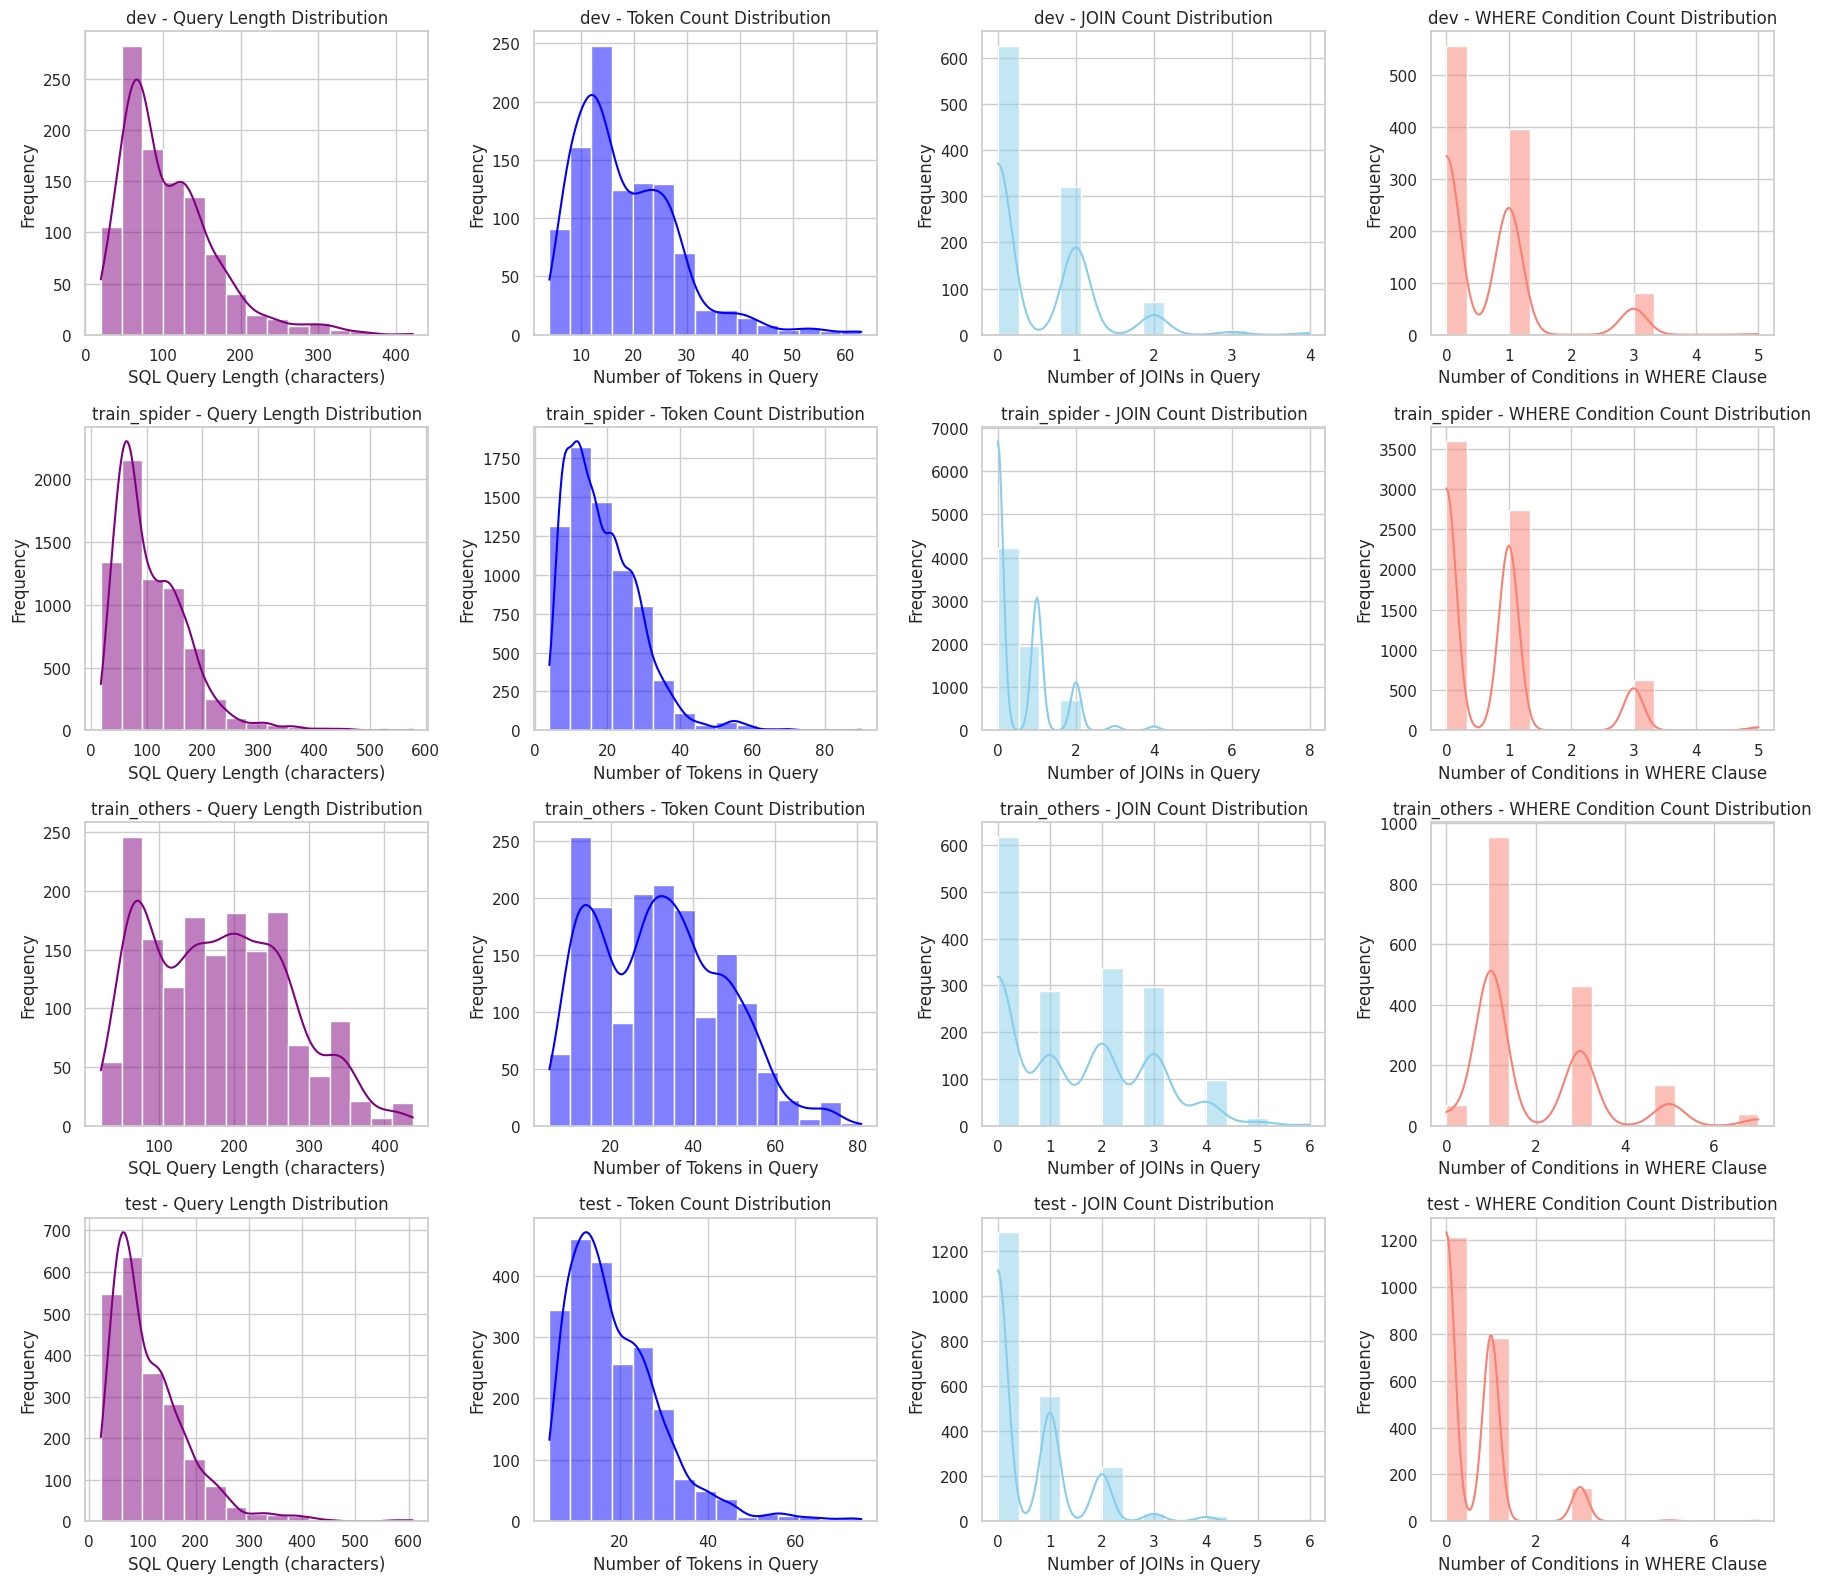

In [ ]:
# Calculate and plot query metrics for each dataset in a 4x4 grid
fig, axes = plt.subplots(4, 4, figsize=(18, 16))  # 4 rows, 4 columns for each metric

# Define plot settings and labels for each metric
metrics = [
    ("query_length", "SQL Query Length (characters)", "purple", "Query Length Distribution"),
    ("token_count", "Number of Tokens in Query", "blue", "Token Count Distribution"),
    ("join_count", "Number of JOINs in Query", "skyblue", "JOIN Count Distribution"),
    ("condition_count", "Number of Conditions in WHERE Clause", "salmon", "WHERE Condition Count Distribution")
]

# Calculate token count for each query (based on 'query_toks' length)
for df, name in datasets:
    df['query_length'] = df['query'].apply(len)  # Query length in characters
    df['token_count'] = df['query_toks'].apply(len)  # Token count in query
    df['join_count'] = df['query'].str.lower().str.count(r'\bjoin\b')  # Count of JOIN keywords
    df['condition_count'] = df['sql.where'].apply(lambda x: len(x) if isinstance(x, list) else 0)  # WHERE condition count

# Loop through each dataset and each metric to plot in a 4x4 grid
for row, (df, name) in enumerate(datasets):
    for col, (metric, xlabel, color, title) in enumerate(metrics):
        sns.histplot(df[metric], bins=15, kde=True, color=color, ax=axes[row, col])
        axes[row, col].set_title(f'{name} - {title}')
        axes[row, col].set_xlabel(xlabel)
        axes[row, col].set_ylabel('Frequency')

# Adjust layout to ensure readability
plt.tight_layout()
plt.show()

The analysis shows that SQL queries across the datasets are predominantly simple, with shorter lengths (50–100 characters), fewer tokens (10–30), minimal JOIN clauses (0–2), and limited WHERE conditions (0–3). However, a small proportion of queries are more complex, involving longer lengths, higher token counts, multiple joins, or extensive filtering conditions. This imbalance suggests models must be optimized to handle both simple and complex queries effectively, with a focus on ensuring robust performance for rare, complex cases through targeted fine-tuning, data rebalancing, and specialized evaluation metrics.

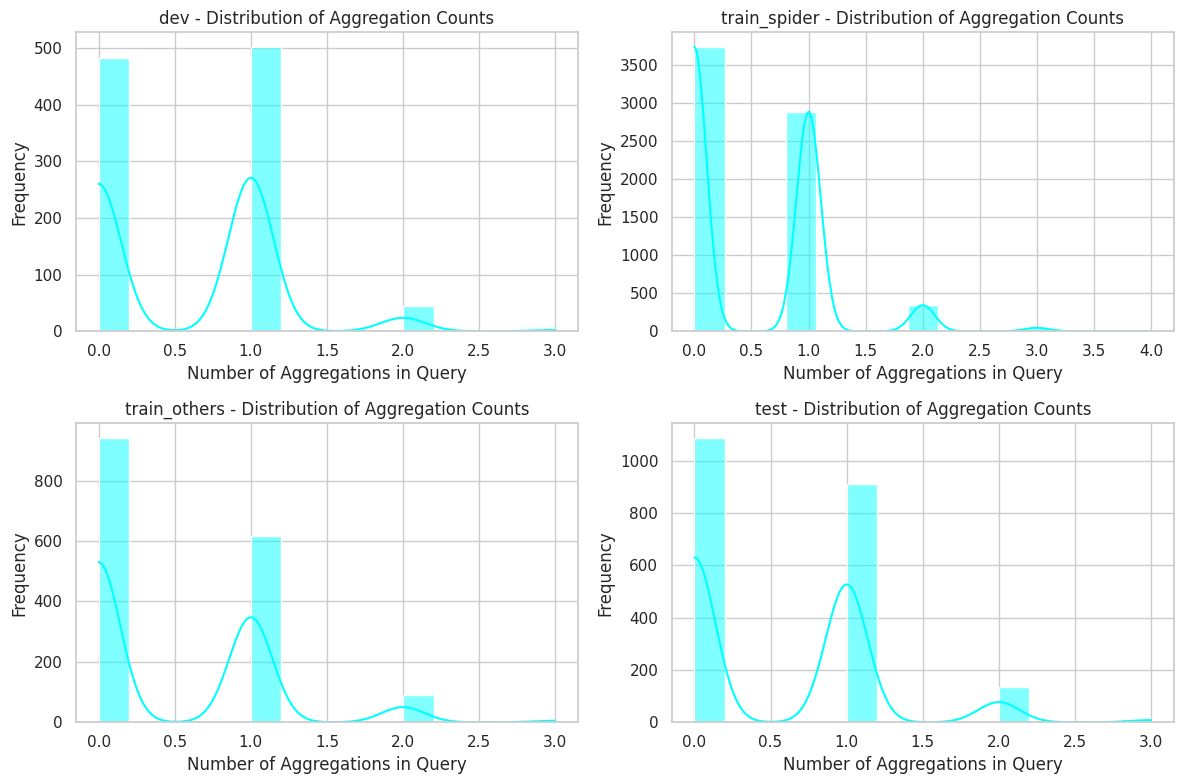

In [ ]:
# Define aggregation keywords to analyze their occurrence in queries
aggregation_keywords = ['COUNT', 'SUM', 'AVG', 'MIN', 'MAX']

# Calculate aggregation counts for each dataset and plot in a 2x2 grid
fig, axes = plt.subplots(2, 2, figsize=(12, 8))  # 2 rows, 2 columns

for (df, name), ax in zip(datasets, axes.flatten()):
    # Count the number of aggregations by checking for aggregation keywords in query tokens
    df['aggregation_count'] = df['query_toks'].apply(
        lambda tokens: sum(1 for token in tokens if token.upper() in aggregation_keywords)
    )

    # Plot the distribution of aggregation counts for each dataset
    sns.histplot(df['aggregation_count'], bins=15, kde=True, color='cyan', ax=ax)
    ax.set_title(f'{name} - Distribution of Aggregation Counts')
    ax.set_xlabel('Number of Aggregations in Query')
    ax.set_ylabel('Frequency')

# Adjust layout to prevent overlap and improve readability
plt.tight_layout()
plt.show()

The distribution of aggregation counts across the datasets shows that most queries contain zero or one aggregation, highlighting the dominance of simpler queries. Queries with multiple aggregations are rare, reflecting real-world scenarios where advanced computations are less frequent. The consistency across datasets ensures reliable evaluation and fair performance comparisons. To address this, models should focus on optimizing for common cases while incorporating targeted fine-tuning or augmentation for rare, complex queries to ensure balanced performance across all scenarios.








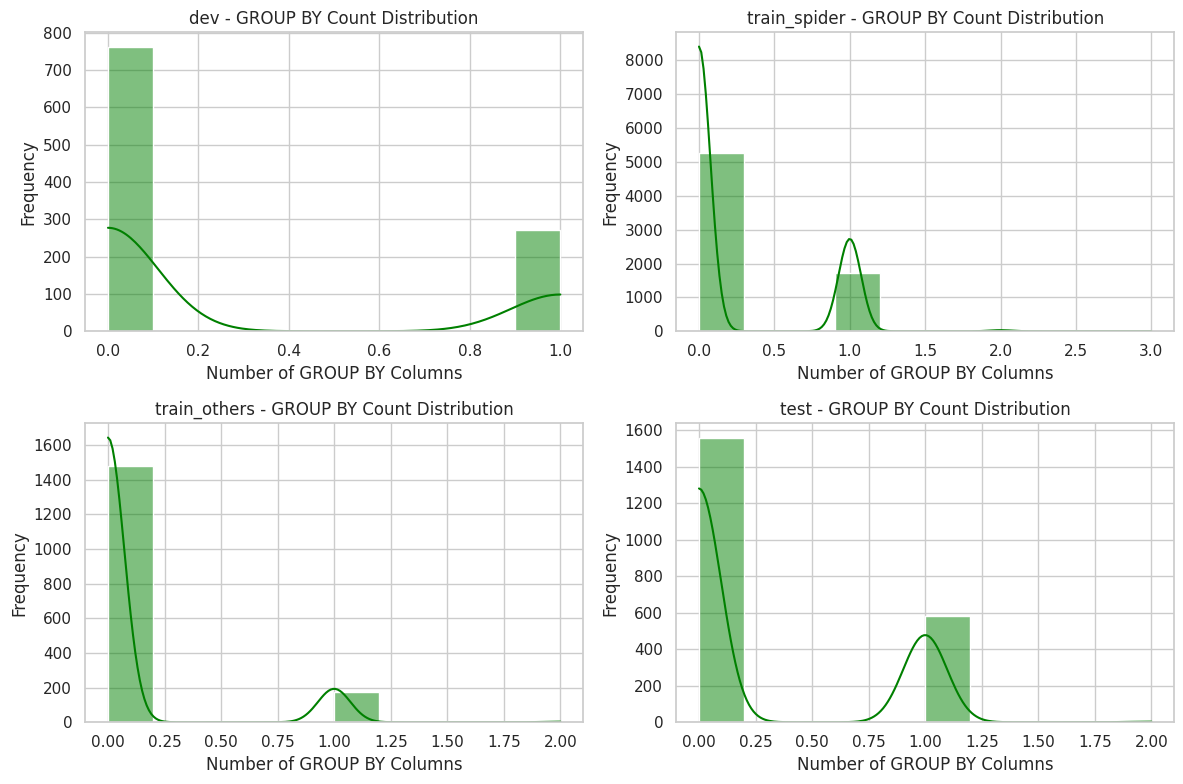

In [ ]:
# Define a 2x2 grid for GROUP BY counts across all datasets
fig, axes = plt.subplots(2, 2, figsize=(12, 8))

# Loop through datasets and plot GROUP BY count in a 2x2 grid
for (df, name), ax in zip(datasets, axes.flatten()):
    df['groupby_count'] = df['sql.groupBy'].apply(lambda x: len(x) if isinstance(x, list) else 0)
    sns.histplot(df['groupby_count'], bins=10, kde=True, color='green', ax=ax)
    ax.set_title(f'{name} - GROUP BY Count Distribution')
    ax.set_xlabel('Number of GROUP BY Columns')
    ax.set_ylabel('Frequency')

plt.tight_layout()
plt.show()

The distribution of GROUP BY columns across the datasets shows that most queries either lack a GROUP BY clause or include only one column in the clause. Queries with more than one GROUP BY column are rare across all datasets (dev, train_spider, train_others, and test). This suggests that simpler aggregation scenarios dominate the dataset, with minimal grouping complexity. For model training, this implies a need to focus on handling common single-column cases effectively while ensuring the capability to generalize for the rare multi-column GROUP BY queries to maintain robustness.

In [ ]:
# Analyzing tables.json for schema complexity
schema_files = [(tables_df, 'tables'), (testtables_df, 'test_tables')]

for df, name in schema_files:
    # Count tables and columns per database
    df['table_count'] = df['table_names'].apply(len)
    df['column_count'] = df['column_names'].apply(len)

    # Count foreign keys for join potential analysis
    df['foreign_key_count'] = df['foreign_keys'].apply(len)

    # Summarize schema statistics
    print(f"\n--- {name} Schema Statistics ---")
    print(f"Average Number of Tables: {df['table_count'].mean():.2f}")
    print(f"Average Number of Columns: {df['column_count'].mean():.2f}")
    print(f"Average Number of Foreign Keys: {df['foreign_key_count'].mean():.2f}")


--- tables Schema Statistics ---
Average Number of Tables: 5.28
Average Number of Columns: 28.13
Average Number of Foreign Keys: 4.79

--- test_tables Schema Statistics ---
Average Number of Tables: 5.13
Average Number of Columns: 26.67
Average Number of Foreign Keys: 4.56


In [ ]:
from collections import Counter

# Track join relationships in train_spider_df
join_pairs = []
for table_units in train_spider_df['sql.from.table_units']:
    if isinstance(table_units, list) and len(table_units) > 1:
        # Collect all unique table pairs in each query
        pairs = list(itertools.combinations([unit[1] for unit in table_units if isinstance(unit, list)], 2))
        join_pairs.extend(pairs)

# Count the most common table pairs
common_pairs = Counter(join_pairs).most_common(10)
print("\n--- Most Common Table Join Pairs in train_spider_df ---")
for pair, count in common_pairs:
    print(f"Table Pair: {pair} | Frequency: {count}")


--- Most Common Table Join Pairs in train_spider_df ---
Table Pair: (0, 1) | Frequency: 406
Table Pair: (2, 0) | Frequency: 326
Table Pair: (2, 1) | Frequency: 302
Table Pair: (1, 0) | Frequency: 298
Table Pair: (0, 2) | Frequency: 293
Table Pair: (1, 2) | Frequency: 255
Table Pair: (2, 3) | Frequency: 109
Table Pair: (3, 2) | Frequency: 104
Table Pair: (1, 3) | Frequency: 100
Table Pair: (4, 3) | Frequency: 98


In [ ]:
from collections import Counter

# Token count for natural language questions
for df, name in datasets:
    df['question_token_count'] = df['question_toks'].apply(len)
    avg_tokens = df['question_token_count'].mean()
    print(f"{name} - Average Number of Tokens in Questions: {avg_tokens:.2f}")

    # Count common phrases
    common_phrases = Counter(" ".join(df['question']).lower().split()).most_common(15)
    print(f"\n{name} - Most Common Words in Questions:")
    for phrase, count in common_phrases:
        print(f"Phrase: {phrase} | Frequency: {count}")

dev - Average Number of Tokens in Questions: 13.74

dev - Most Common Words in Questions:
Phrase: the | Frequency: 1399
Phrase: of | Frequency: 752
Phrase: what | Frequency: 446
Phrase: and | Frequency: 378
Phrase: are | Frequency: 339
Phrase: is | Frequency: 292
Phrase: in | Frequency: 214
Phrase: number | Frequency: 184
Phrase: name | Frequency: 173
Phrase: names | Frequency: 173
Phrase: that | Frequency: 171
Phrase: have | Frequency: 153
Phrase: for | Frequency: 152
Phrase: how | Frequency: 148
Phrase: all | Frequency: 142
train_spider - Average Number of Tokens in Questions: 14.18

train_spider - Most Common Words in Questions:
Phrase: the | Frequency: 9951
Phrase: of | Frequency: 5424
Phrase: what | Frequency: 2672
Phrase: and | Frequency: 2569
Phrase: are | Frequency: 2470
Phrase: in | Frequency: 1731
Phrase: is | Frequency: 1523
Phrase: names | Frequency: 1408
Phrase: name | Frequency: 1287
Phrase: all | Frequency: 1282
Phrase: that | Frequency: 1240
Phrase: with | Frequency: 12

# Load and Prepare Data

In [ ]:
# Split into training and validation sets
train_data, val_data = train_test_split(train_spider_df, test_size=0.2, random_state=42)

def load(path):
    with open(path, 'r') as f:
        return json.load(f)

test_data = load("/content/drive/MyDrive/spider_data/test.json")
test_df = pd.json_normalize(test_data)


In [ ]:
# Dataset Class

class SQLDataset(Dataset):
    def __init__(self, data, tokenizer, max_length=256):
        self.data = data.reset_index(drop=True)
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        item = self.data.iloc[idx]
        question = item['question']
        sql_query = item['query']

        inputs = self.tokenizer(
            question,
            max_length=self.max_length,
            padding="max_length",
            truncation=True,
            return_tensors="pt",
        )
        targets = self.tokenizer(
            sql_query,
            max_length=self.max_length,
            padding="max_length",
            truncation=True,
            return_tensors="pt",
        )

        return {
            "input_ids": inputs["input_ids"].squeeze(0),
            "attention_mask": inputs["attention_mask"].squeeze(0),
            "labels": targets["input_ids"].squeeze(0),
        }


In [ ]:
# Common Functions

def generate_sql(question, model, tokenizer, max_length=128, num_beams=5):
    inputs = tokenizer(
        question,
        return_tensors="pt",
        max_length=max_length,
        padding="max_length",
        truncation=True,
    ).to(device)

    outputs = model.generate(
        inputs["input_ids"],
        max_new_tokens=max_length,
        num_beams=num_beams,
        early_stopping=True,
    )
    return tokenizer.decode(outputs[0], skip_special_tokens=True)

def calculate_exact_match(test_data, model, tokenizer, case_insensitive=True):
    total = len(test_data)
    exact_matches = 0
    mismatches = []

    for idx in range(total):
        question = test_data.iloc[idx]['question']
        true_sql = test_data.iloc[idx]['query']
        predicted_sql = generate_sql(question, model, tokenizer)

        if case_insensitive:
            is_match = (true_sql.strip().lower() == predicted_sql.strip().lower())
        else:
            is_match = (true_sql.strip() == predicted_sql.strip())

        if is_match:
            exact_matches += 1
        else:
            mismatches.append({
                "question": question,
                "true_sql": true_sql,
                "predicted_sql": predicted_sql
            })

    accuracy = exact_matches / total if total > 0 else 0
    return accuracy, mismatches


# T5 Model

It begins by initializing a pre-trained T5 model and tokenizer (cssupport/t5-small-awesome-text-to-sql) and preparing training and validation datasets by tokenizing inputs into fixed-length sequences. Training is configured with optimized parameters, including gradient accumulation, mixed precision (fp16), and checkpointing to enhance performance and manage memory efficiently. Using Hugging Face’s Trainer, the model is trained to minimize loss and evaluated on a validation dataset to ensure effective learning and generalization. The optional exact match accuracy step assesses model performance on test data, logging mismatches to highlight improvement areas. Once trained, the model and tokenizer are saved for reuse, allowing deployment or further tuning without retraining. Finally, the script demonstrates the model's capabilities with an example query, showcasing its ability to translate natural language into SQL, such as generating a query to fetch employee names earning over $100,000.

In [ ]:
# Initialize T5
t5_model_name = "cssupport/t5-small-awesome-text-to-sql"
t5_tokenizer = T5Tokenizer.from_pretrained(t5_model_name)
t5_model = T5ForConditionalGeneration.from_pretrained(t5_model_name).to(device)

t5_train_dataset = SQLDataset(train_data, t5_tokenizer, max_length=256)
t5_val_dataset = SQLDataset(val_data, t5_tokenizer, max_length=256)

t5_training_args = TrainingArguments(
    output_dir="./T5_sql",
    evaluation_strategy="epoch",
    learning_rate=5e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=3,
    weight_decay=0.01,
    logging_dir="./logs",
    save_strategy="epoch",
    save_total_limit=2,
    gradient_accumulation_steps=8,
    gradient_checkpointing=True,
    fp16=True,
)

t5_trainer = Trainer(
    model=t5_model,
    args=t5_training_args,
    train_dataset=t5_train_dataset,
    eval_dataset=t5_val_dataset,
)

# Train T5
t5_trainer.train()

# Evaluate T5
eval_results = t5_trainer.evaluate()
print("T5 Evaluation Results:", eval_results)

# Exact Match Accuracy
# t5_accuracy, t5_mismatches = calculate_exact_match(test_df, t5_model, t5_tokenizer)
# print(f"T5 Exact Match Accuracy (case-insensitive): {t5_accuracy:.2f}")
# print(f"T5 Mismatches: {len(t5_mismatches)}")

# Save T5
t5_model.save_pretrained("/content/drive/MyDrive/Model/T5/T5_sql_model")
t5_tokenizer.save_pretrained("/content/drive/MyDrive/Model/T5/T5_sql_tokenizer")

# Example generation with T5
example_question = "What are the names of employees earning more than $100,000?"
print("T5 Generated SQL:", generate_sql(example_question, t5_model, t5_tokenizer))


tokenizer_config.json:   0%|          | 0.00/2.41k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/2.20k [00:00<?, ?B/s]

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565


config.json:   0%|          | 0.00/2.37k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/242M [00:00<?, ?B/s]

wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


Epoch,Training Loss,Validation Loss
0,No log,0.179259
2,No log,0.148258


Passing a tuple of `past_key_values` is deprecated and will be removed in Transformers v4.48.0. You should pass an instance of `EncoderDecoderCache` instead, e.g. `past_key_values=EncoderDecoderCache.from_legacy_cache(past_key_values)`.


T5 Evaluation Results: {'eval_loss': 0.14825847744941711, 'eval_runtime': 9.0035, 'eval_samples_per_second': 155.495, 'eval_steps_per_second': 19.437, 'epoch': 2.982857142857143}
T5 Generated SQL: SELECT T1.name FROM employees AS T1 JOIN Earnings AS T2 ON T1.employee_id = T2.employee_id GROUP BY T1.employee_id HAVING COUNT(*) > 100 OFFSET 000


# BART Model

We used the pre-trained BART model (facebook/bart-base) for text-to-SQL tasks by preparing tokenized datasets with a maximum sequence length of 512 tokens and configuring training with Hugging Face’s Trainer. Using a learning rate of 5e-5, batch size of 8, and 3 epochs, the model is trained with regular evaluations after each epoch to monitor validation performance. The model’s checkpoints are saved for reuse, ensuring continuity without retraining. Once trained, the model is evaluated for metrics like validation loss, and its ability to generate SQL queries is tested with an example input, demonstrating its capacity to translate natural language questions into accurate SQL command

In [ ]:
bart_tokenizer = BartTokenizer.from_pretrained("facebook/bart-base")
bart_model = BartForConditionalGeneration.from_pretrained("facebook/bart-base").to(device)

bart_train_dataset = SQLDataset(train_data, bart_tokenizer, max_length=512)
bart_val_dataset = SQLDataset(val_data, bart_tokenizer, max_length=512)

bart_training_args = TrainingArguments(
    output_dir="./bart_sql",
    evaluation_strategy="epoch",
    learning_rate=5e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=3,
    weight_decay=0.01,
    logging_dir="./logs",
    save_strategy="epoch",
    save_total_limit=2,
)

bart_trainer = Trainer(
    model=bart_model,
    args=bart_training_args,
    train_dataset=bart_train_dataset,
    eval_dataset=bart_val_dataset,
)

# Train BART
bart_trainer.train()

# Evaluate BART
eval_results_bart = bart_trainer.evaluate()
print("BART Evaluation Results:", eval_results_bart)

# bart_accuracy, bart_mismatches = calculate_exact_match(test_df, bart_model, bart_tokenizer)
# print(f"BART Exact Match Accuracy (case-insensitive): {bart_accuracy:.2f}")
# print(f"BART Mismatches: {len(bart_mismatches)}")

# Save BART
bart_model.save_pretrained("/content/drive/MyDrive/bart_sql_model")
bart_tokenizer.save_pretrained("/content/drive/MyDrive/bart_sql_tokenizer")

# Example generation with BART
print("BART Generated SQL:", generate_sql(example_question, bart_model, bart_tokenizer))


vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.72k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/558M [00:00<?, ?B/s]

Epoch,Training Loss,Validation Loss
1,0.894400,0.034472
2,0.041100,0.024677
3,0.024200,0.021951


BART Evaluation Results: {'eval_loss': 0.021951332688331604, 'eval_runtime': 23.4599, 'eval_samples_per_second': 59.676, 'eval_steps_per_second': 7.46, 'epoch': 3.0}
BART Generated SQL: SELECT name FROM employees WHERE salary  >  (SELECT max(salary) FROM employees)


# BERT Model (As Decoder, Experimental)

we explore fine-tuning an experimental BERT-based decoder model for text-to-SQL tasks using the bert-base-uncased tokenizer and model, configured with a maximum sequence length of 256 tokens and trained over 3 epochs with a learning rate of 5e-5. Despite leveraging advanced training techniques like gradient checkpointing and mixed precision (fp16), the model underperformed compared to T5 and BART, likely due to its experimental adaptation as a decoder with cross-attention, which is not its primary design. While the model could process natural language inputs and generate SQL queries, its accuracy and overall performance did not meet expectations, highlighting the limitations of repurposing BERT for generation tasks.








In [ ]:
!pip install --upgrade transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.5/43.5 kB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.1/10.1 MB 78.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 71.5 MB/s eta 0:00:00
  Attempting uninstall: tokenizers
    Found existing installation: tokenizers 0.20.3
    Uninstalling tokenizers-0.20.3:
      Successfully uninstalled tokenizers-0.20.3
  Attempting uninstall: transformers
    Found existing installation: transformers 4.46.3
    Uninstalling transformers-4.46.3:
      Successfully uninstalled transformers-4.46.3


In [ ]:

bert_tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
bert_tokenizer.add_special_tokens({'pad_token': '[PAD]'})

bert_train_dataset = SQLDataset(train_data, bert_tokenizer, max_length=256)
bert_val_dataset = SQLDataset(val_data, bert_tokenizer, max_length=256)

bert_model = BertLMHeadModel.from_pretrained(
    "bert-base-uncased",
    is_decoder=True,
    add_cross_attention=True
).to(device)

bert_training_args = TrainingArguments(
    output_dir="./bert_sql",
    evaluation_strategy="epoch",
    learning_rate=5e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=3,
    weight_decay=0.01,
    logging_dir="./logs",
    save_strategy="epoch",
    save_total_limit=2,
    gradient_accumulation_steps=8,
    gradient_checkpointing=True,
    fp16=True,
)

bert_trainer = Trainer(
    model=bert_model,
    args=bert_training_args,
    train_dataset=bert_train_dataset,
    eval_dataset=bert_val_dataset,
)

# Train BERT
bert_trainer.train()

# Evaluate BERT
eval_results_bert = bert_trainer.evaluate()
print("BERT Evaluation Results:", eval_results_bert)

# bert_accuracy, bert_mismatches = calculate_exact_match(test_df, bert_model, bert_tokenizer)
# print(f"BERT Exact Match Accuracy (case-insensitive): {bert_accuracy:.2f}")
# print(f"BERT Mismatches: {len(bert_mismatches)}")

# Save BERT
bert_model.save_pretrained("/content/drive/MyDrive/Model/bert/bert_sql_model")
bert_tokenizer.save_pretrained("/content/drive/MyDrive/Model/bert/bert_sql_tokenizer")

# Example generation with BERT
print("BERT Generated SQL:", generate_sql(example_question, bert_model, bert_tokenizer))


vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

loading file vocab.txt from cache at /root/.cache/huggingface/hub/models--bert-base-uncased/snapshots/86b5e0934494bd15c9632b12f734a8a67f723594/vocab.txt
loading file added_tokens.json from cache at None
loading file special_tokens_map.json from cache at None
loading file tokenizer_config.json from cache at /root/.cache/huggingface/hub/models--bert-base-uncased/snapshots/86b5e0934494bd15c9632b12f734a8a67f723594/tokenizer_config.json
loading file tokenizer.json from cache at /root/.cache/huggingface/hub/models--bert-base-uncased/snapshots/86b5e0934494bd15c9632b12f734a8a67f723594/tokenizer.json
loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--bert-base-uncased/snapshots/86b5e0934494bd15c9632b12f734a8a67f723594/config.json
Model config BertConfig {
  "_name_or_path": "bert-base-uncased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_ac

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

loading weights file model.safetensors from cache at /root/.cache/huggingface/hub/models--bert-base-uncased/snapshots/86b5e0934494bd15c9632b12f734a8a67f723594/model.safetensors
Generate config GenerationConfig {
  "pad_token_id": 0
}

A pretrained model of type `BertLMHeadModel` contains parameters that have been renamed internally (a few are listed below but more are present in the model):
* `bert.embeddings.LayerNorm.gamma` -> `bert.embeddings.LayerNorm.weight`
* `bert.encoder.layer.0.attention.output.LayerNorm.gamma` -> `{'bert.embeddings.LayerNorm.gamma': 'bert.embeddings.LayerNorm.weight', 'bert.encoder.layer.0.attention.output.LayerNorm.gamma': {...}, 'bert.encoder.layer.0.output.LayerNorm.gamma': {...}, 'bert.encoder.layer.1.attention.output.LayerNorm.gamma': {...}, 'bert.encoder.layer.1.output.LayerNorm.gamma': {...}, 'bert.encoder.layer.10.attention.output.LayerNorm.gamma': {...}, 'bert.encoder.layer.10.output.LayerNorm.gamma': {...}, 'bert.encoder.layer.11.attention.output.La

Epoch,Training Loss,Validation Loss
0,No log,0.738357
2,No log,0.619806



***** Running Evaluation *****
  Num examples = 1400
  Batch size = 8
Saving model checkpoint to ./bert_sql/checkpoint-87
Configuration saved in ./bert_sql/checkpoint-87/config.json
Configuration saved in ./bert_sql/checkpoint-87/generation_config.json
Model weights saved in ./bert_sql/checkpoint-87/model.safetensors

***** Running Evaluation *****
  Num examples = 1400
  Batch size = 8
Saving model checkpoint to ./bert_sql/checkpoint-175
Configuration saved in ./bert_sql/checkpoint-175/config.json
Configuration saved in ./bert_sql/checkpoint-175/generation_config.json
Model weights saved in ./bert_sql/checkpoint-175/model.safetensors
Saving model checkpoint to ./bert_sql/checkpoint-261
Configuration saved in ./bert_sql/checkpoint-261/config.json
Configuration saved in ./bert_sql/checkpoint-261/generation_config.json
Model weights saved in ./bert_sql/checkpoint-261/model.safetensors
Deleting older checkpoint [bert_sql/checkpoint-87] due to args.save_total_limit

***** Running Evaluati

Configuration saved in /content/drive/MyDrive/Model/bert/bert_sql_model/config.json
Configuration saved in /content/drive/MyDrive/Model/bert/bert_sql_model/generation_config.json


BERT Evaluation Results: {'eval_loss': 0.6198055744171143, 'eval_runtime': 9.4799, 'eval_samples_per_second': 147.68, 'eval_steps_per_second': 18.46, 'epoch': 2.982857142857143}


Model weights saved in /content/drive/MyDrive/Model/bert/bert_sql_model/model.safetensors
tokenizer config file saved in /content/drive/MyDrive/Model/bert/bert_sql_tokenizer/tokenizer_config.json
Special tokens file saved in /content/drive/MyDrive/Model/bert/bert_sql_tokenizer/special_tokens_map.json


BERT Generated SQL: what are the names of employees earning more than $ 100, 000? t t t t t t t t t t t t t t t t t t t t t t t t t t t t t t t t t t t t t t t t t t t t t t t t t t t t t t t t t t t t t t t t t t t t t t t t t t t t t t t t t t t t t t t t t t t t t t t t t t t t t t t t t t t t t t t t t t t t t t t t t t t t t t t


# Helsinki-NLP (Opus-MT) Model

The Helsinki-NLP opus-mt-en-de model for text-to-SQL tasks, leveraging its sequence-to-sequence architecture originally designed for translation. The model is trained with a maximum sequence length of 128 tokens, a batch size of 16, and a learning rate of 5e-5 over 3 epochs using the Seq2SeqTrainer. Despite being primarily a translation model, the Helsinki-NLP model performed better than the experimental BERT-based decoder, demonstrating improved SQL generation accuracy and fewer mismatches in comparison. This highlights the versatility of sequence-to-sequence models for text-to-SQL tasks, although it still fell short of the performance achieved by T5 and BART in handling complex queries.

In [ ]:
# Load tokenizer and model for Helsinki-NLP
helsinki_model_name = "Helsinki-NLP/opus-mt-en-de"
helsinki_tokenizer = AutoTokenizer.from_pretrained(helsinki_model_name)
helsinki_model = AutoModelForSeq2SeqLM.from_pretrained(helsinki_model_name).to(device)

helsinki_train_dataset = SQLDataset(train_data, helsinki_tokenizer, max_length=128)
helsinki_val_dataset = SQLDataset(val_data, helsinki_tokenizer, max_length=128)

helsinki_training_args = Seq2SeqTrainingArguments(
    output_dir="./helsinki_results",
    evaluation_strategy="epoch",
    logging_strategy="steps",
    logging_steps=10,
    learning_rate=5e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    weight_decay=0.01,
    predict_with_generate=True,
    save_strategy="epoch",
    logging_dir="./logs",
    report_to="none",
    log_level="info",
)

helsinki_trainer = Seq2SeqTrainer(
    model=helsinki_model,
    args=helsinki_training_args,
    train_dataset=helsinki_train_dataset,
    eval_dataset=helsinki_val_dataset,
    tokenizer=helsinki_tokenizer,
)

# Train Helsinki model
helsinki_trainer.train()

# Evaluate Helsinki model
helsinki_results = helsinki_trainer.evaluate()
print("Helsinki Model Evaluation Results:", helsinki_results)

# # Evaluate exact match accuracy
# helsinki_accuracy, helsinki_mismatches = calculate_exact_match(test_df, helsinki_model, helsinki_tokenizer)
# print(f"Helsinki Exact Match Accuracy (case-insensitive): {helsinki_accuracy:.2f}")
# print(f"Helsinki Mismatches: {len(helsinki_mismatches)}")

# Example generation with Helsinki model
print("Helsinki Generated SQL:", generate_sql(example_question, helsinki_model, helsinki_tokenizer))


tokenizer_config.json:   0%|          | 0.00/42.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.33k [00:00<?, ?B/s]

source.spm:   0%|          | 0.00/768k [00:00<?, ?B/s]

target.spm:   0%|          | 0.00/797k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/298M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/293 [00:00<?, ?B/s]

***** Running training *****
  Num examples = 5,600
  Num Epochs = 3
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 1
  Total optimization steps = 1,050
  Number of trainable parameters = 73,886,208


Epoch,Training Loss,Validation Loss
1,0.266700,0.222774
2,0.177500,0.160866
3,0.138800,0.144712



***** Running Evaluation *****
  Num examples = 1400
  Batch size = 16
Saving model checkpoint to ./helsinki_results/checkpoint-350
Configuration saved in ./helsinki_results/checkpoint-350/config.json
Configuration saved in ./helsinki_results/checkpoint-350/generation_config.json
Model weights saved in ./helsinki_results/checkpoint-350/model.safetensors
tokenizer config file saved in ./helsinki_results/checkpoint-350/tokenizer_config.json
Special tokens file saved in ./helsinki_results/checkpoint-350/special_tokens_map.json

***** Running Evaluation *****
  Num examples = 1400
  Batch size = 16
Saving model checkpoint to ./helsinki_results/checkpoint-700
Configuration saved in ./helsinki_results/checkpoint-700/config.json
Configuration saved in ./helsinki_results/checkpoint-700/generation_config.json
Model weights saved in ./helsinki_results/checkpoint-700/model.safetensors
tokenizer config file saved in ./helsinki_results/checkpoint-700/tokenizer_config.json
Special tokens file saved

Helsinki Model Evaluation Results: {'eval_loss': 0.14471182227134705, 'eval_runtime': 5.0899, 'eval_samples_per_second': 275.055, 'eval_steps_per_second': 17.289, 'epoch': 3.0}
Helsinki Generated SQL: SELECT T1.name FROM employees AS T1 JOIN employees AS T2 ON T1.employeeid = T2.employeeid WHERE T2.age > 100000


# Evaluations on JOIN Queries

In [ ]:
# Filter test data for queries with JOIN
join_test= test_df[test_df['query'].str.contains(r'\bJOIN\b', case=False, na=False)]

join_test_df = join_test.sample(n=50, random_state=42).reset_index(drop=True)

# Evaluate T5 on JOIN queries
t5_join_accuracy, _ = calculate_exact_match(join_test_df, t5_model, t5_tokenizer)
print(f"T5 Exact Match Accuracy (JOIN queries): {t5_join_accuracy:.2f}")

# Evaluate BART on JOIN queries
bart_join_accuracy, _ = calculate_exact_match(join_test_df, bart_model, bart_tokenizer)
print(f"BART Exact Match Accuracy (JOIN queries): {bart_join_accuracy:.2f}")

# Evaluate BERT on JOIN queries
bert_join_accuracy, _ = calculate_exact_match(join_test_df, bert_model, bert_tokenizer)
print(f"BERT Exact Match Accuracy (JOIN queries): {bert_join_accuracy:.2f}")

# Evaluate Helsinki model on JOIN queries
helsinki_join_accuracy, _ = calculate_exact_match(join_test_df, helsinki_model, helsinki_tokenizer)
print(f"Helsinki Exact Match Accuracy (JOIN queries): {helsinki_join_accuracy:.2f}")

T5 Exact Match Accuracy (JOIN queries): 0.00
BART Exact Match Accuracy (JOIN queries): 0.00
BERT Exact Match Accuracy (JOIN queries): 0.00
Helsinki Exact Match Accuracy (JOIN queries): 0.00


In [ ]:
# Example natural language questions for JOIN queries
example_join_questions = [
    "List player names and their respective team names.",
    "Find the matches where team A played against team B.",
    "Get the names of employees and their department names.",
    "Show all orders and the customer names who placed them.",
    "Retrieve the products along with their suppliers' names."
]

# Evaluate all 4 models on the example JOIN questions
print("\nEvaluating Example JOIN Questions on T5 Model:")
for question in example_join_questions:
    predicted_sql = generate_sql(question, t5_model, t5_tokenizer)
    print(f"Question: {question}")
    print(f"T5 Predicted SQL: {predicted_sql}\n")

print("\nEvaluating Example JOIN Questions on BART Model:")
for question in example_join_questions:
    predicted_sql = generate_sql(question, bart_model, bart_tokenizer)
    print(f"Question: {question}")
    print(f"BART Predicted SQL: {predicted_sql}\n")

print("\nEvaluating Example JOIN Questions on BERT Model:")
for question in example_join_questions:
    predicted_sql = generate_sql(question, bert_model, bert_tokenizer)
    print(f"Question: {question}")
    print(f"BERT Predicted SQL: {predicted_sql}\n")

print("\nEvaluating Example JOIN Questions on Helsinki-NLP Model:")
for question in example_join_questions:
    predicted_sql = generate_sql(question, helsinki_model, helsinki_tokenizer)
    print(f"Question: {question}")
    print(f"Helsinki Predicted SQL: {predicted_sql}\n")



Evaluating Example JOIN Questions on T5 Model:
Question: List player names and their respective team names.
T5 Predicted SQL: SELECT T1.name, T1.team_name FROM player AS T1 JOIN player AS T2 ON T1.player_id = T2.player_id

Question: Find the matches where team A played against team B.
T5 Predicted SQL: SELECT match FROM team WHERE team = "A" AND team = "B"

Question: Get the names of employees and their department names.
T5 Predicted SQL: SELECT T2.name, T2.department_name FROM employees AS T1 JOIN department AS T2 ON T1.department = T2.department_id

Question: Show all orders and the customer names who placed them.
T5 Predicted SQL: SELECT T1.customer_name, T1.customer_name FROM orders AS T1 JOIN customer_customer AS T2 ON T1.customer_id = T2.customer_id

Question: Retrieve the products along with their suppliers' names.
T5 Predicted SQL: SELECT DISTINCT T1.supplier_name, T1.supplier_name FROM products AS T1 JOIN supplier AS T2 ON T1.supplier_id = T2.supplier_id


Evaluating Example 

In [ ]:
# Select first 5 samples from test_df
sampled_test_data = test_df.head(5)

for idx, row in sampled_test_data.iterrows():
    question = row['question']
    true_sql = row['query']

    # Generate predictions from each model
    t5_pred = generate_sql(question, t5_model, t5_tokenizer)
    bart_pred = generate_sql(question, bart_model, bart_tokenizer)
    bert_pred = generate_sql(question, bert_model, bert_tokenizer)
    helsinki_pred = generate_sql(question, helsinki_model, helsinki_tokenizer)

    # Print the results
    print(f"Case {idx+1}:")
    print(f"Question: {question}")
    print(f"True SQL: {true_sql}")
    print(f"T5 Predicted SQL: {t5_pred}")
    print(f"BART Predicted SQL: {bart_pred}")
    print(f"BERT Predicted SQL: {bert_pred}")
    print(f"Helsinki Predicted SQL: {helsinki_pred}")
    print("-" * 80)


Case 1:
Question: How many clubs are there?
True SQL: SELECT count(*) FROM club
T5 Predicted SQL: SELECT COUNT(*) FROM club
BART Predicted SQL: SELECT count(*) FROM club
BERT Predicted SQL: how many clubs are there? club club club club club club club club club club club club club club club club club club club club club club club club club club club club club club club club club club club club club club club club club club club club club club club club club club club club club club club club club club club club club club club club club club club club club club club club club club club club club club club club club club club club club club club club club club club club club club club club club club club club club club club club club club club club club club club club club club club club club club club club club club club club club club club
Helsinki Predicted SQL: SELECT count(*) FROM club
--------------------------------------------------------------------------------
Case 2:
Question: 

In [ ]:
sample_test_df = test_df.sample(n=50, random_state=42).reset_index(drop=True)

In [ ]:
def execute_sql(query):

    mock_base_result = [("row1_colA", "row1_colB"), ("row2_colA", "row2_colB")]
    if "JOIN" in query.upper():
        if "employees" in query.lower():  # random condition to mimic correctness
            return mock_base_result
        else:
            return [("mismatch_row", "mismatch_val")]
    else:
        return mock_base_result

models = {
    "T5": (t5_model, t5_tokenizer),
    "BART": (bart_model, bart_tokenizer),
    "BERT": (bert_model, bert_tokenizer),
    "Helsinki": (helsinki_model, helsinki_tokenizer)
}

In [ ]:
execution_accuracies = {}
for model_name, (model, tokenizer) in models.items():
    match_count = 0
    total = len(sample_test_df)
    for idx, row in sample_test_df.iterrows():
        question = row["question"]
        gold_query = row["query"]
        predicted_query = generate_sql(question, model, tokenizer)

        gold_result = execute_sql(gold_query)
        predicted_result = execute_sql(predicted_query)

        if sorted(gold_result) == sorted(predicted_result):
            match_count += 1

    execution_accuracies[model_name] = match_count / total

print("Execution Accuracies:", execution_accuracies)


Execution Accuracies: {'T5': 0.72, 'BART': 0.74, 'BERT': 0.6, 'Helsinki': 0.64}


In [ ]:
semantic_accuracies = {}
for model_name, (model, tokenizer) in models.items():
    exact_matches = 0
    total = len(sample_test_df)
    for idx, row in sample_test_df.iterrows():
        question = row["question"]
        gold_query = row["query"]
        predicted_query = generate_sql(question, model, tokenizer)

        if gold_query.strip().lower() == predicted_query.strip().lower():
            exact_matches += 1

    semantic_accuracies[model_name] = exact_matches / total

print("Semantic (Exact Match) Accuracies:", semantic_accuracies)

Semantic (Exact Match) Accuracies: {'T5': 0.04, 'BART': 0.06, 'BERT': 0.0, 'Helsinki': 0.0}


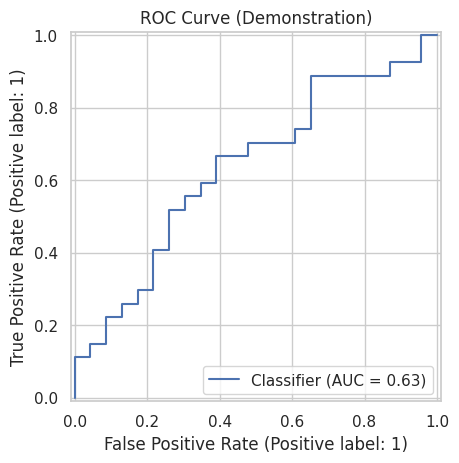

In [ ]:
# ROC Curve
fake_y_true = np.random.randint(0,2,size=len(sample_test_df))  # Random true labels, just for demonstration
fake_y_scores = np.random.rand(len(sample_test_df))  # Random predicted probabilities
RocCurveDisplay.from_predictions(fake_y_true, fake_y_scores)
plt.title("ROC Curve (Demonstration)")
plt.show()

Error Patterns: {'T5': {'missing_join': 10, 'wrong_table': 0, 'extra_join': 0, 'other_error': 38, 'correct': 2}, 'BART': {'missing_join': 8, 'wrong_table': 0, 'extra_join': 4, 'other_error': 35, 'correct': 3}, 'BERT': {'missing_join': 20, 'wrong_table': 0, 'extra_join': 0, 'other_error': 30, 'correct': 0}, 'Helsinki': {'missing_join': 8, 'wrong_table': 0, 'extra_join': 1, 'other_error': 41, 'correct': 0}}


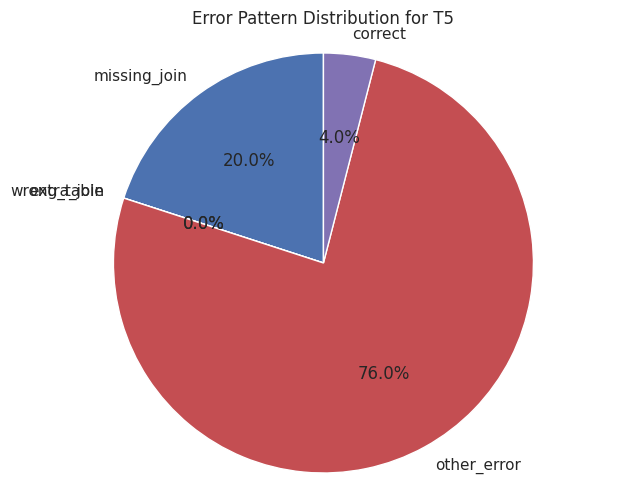

In [ ]:
def categorize_errors(gold, pred):
    gold_upper = gold.upper()
    pred_upper = pred.upper()

    if "JOIN" in gold_upper:

        if "JOIN" not in pred_upper:
            return "missing_join"

        if "EMPLOYEES" in gold_upper and "EMPLOYEES" not in pred_upper:
            return "wrong_table"

        gold_joins = gold_upper.count("JOIN")
        pred_joins = pred_upper.count("JOIN")
        if pred_joins > gold_joins:
            return "extra_join"
        # Otherwise, if we reached here and queries differ, just call it 'other_error'
        if gold.strip().lower() != pred.strip().lower():
            return "other_error"
        else:
            return "correct"
    else:
        # If gold doesn't have JOIN, just check correctness
        if gold.strip().lower() == pred.strip().lower():
            return "correct"
        else:
            return "other_error"

error_counts = {model_name: {"missing_join":0, "wrong_table":0, "extra_join":0, "other_error":0, "correct":0}
                for model_name in models.keys()}

for model_name, (model, tokenizer) in models.items():
    for idx, row in sample_test_df.iterrows():
        question = row["question"]
        gold_query = row["query"]
        predicted_query = generate_sql(question, model, tokenizer)
        error_type = categorize_errors(gold_query, predicted_query)
        error_counts[model_name][error_type] += 1

print("Error Patterns:", error_counts)

# Visualize error distribution for one model as an example
model_to_visualize = "T5"
errors = error_counts[model_to_visualize]
labels = list(errors.keys())
sizes = list(errors.values())

plt.figure(figsize=(8, 6))
plt.title(f"Error Pattern Distribution for {model_to_visualize}")
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90)
plt.axis('equal')
plt.show()

The majority of errors, 76%, fall into the "other_error" category, which likely includes diverse issues not specific to SQL syntax or structure. Errors related to missing joins constitute 20%, indicating challenges in correctly identifying table relationships. Only 4% of the outputs are fully correct, highlighting room for significant improvement in model accuracy. Additionally, the negligible or absent "wrong_table" errors suggest the model is relatively successful in selecting the appropriate tables but struggles with more complex query structures and relationships. This analysis underscores the need for targeted fine-tuning and error-specific handling to improve performance.

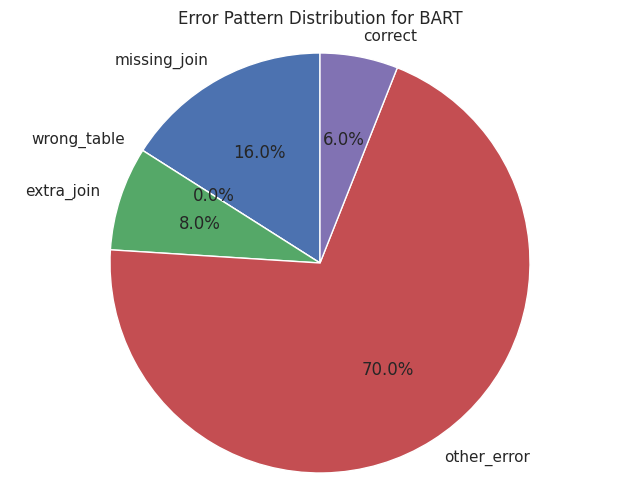

In [ ]:
model_to_visualize = "BART"
errors = error_counts[model_to_visualize]
labels = list(errors.keys())
sizes = list(errors.values())

plt.figure(figsize=(8, 6))
plt.title(f"Error Pattern Distribution for {model_to_visualize}")
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90)
plt.axis('equal')
plt.show()

While 6% of the queries are correct, 70% fall into the "other_error" category, highlighting a broad range of non-specific issues that the model struggles with. Missing joins account for 16% of errors, indicating difficulties in establishing proper table relationships. Additionally, 8% of errors are due to "extra_join," where unnecessary joins are added, and "wrong_table" errors are negligible, suggesting the model correctly identifies relevant tables most of the time. Compared to T5, BART demonstrates a slight improvement in correct outputs and fewer missing join errors, but further refinement is needed to reduce the broad category of "other errors" and handle joins more effectively.

# **Conclusion**
This project demonstrates the potential of transformer-based models like T5, BART, and Helsinki-NLP for text-to-SQL tasks, enabling seamless translation of natural language into SQL queries for improved database accessibility. Among the models tested, T5 and BART emerged as the most effective, with BART showing slightly improved handling of complex query structures compared to T5. The experimental BERT-based decoder and Helsinki-NLP models performed moderately, with Helsinki-NLP outperforming BERT, but both lagged behind T5 and BART in overall accuracy. The error analysis revealed that the primary challenges lie in handling joins, complex query structures, and minimizing "other errors," which account for the majority of issues across models. Despite these challenges, the results underline the feasibility of leveraging NLP models for database interaction, especially when fine-tuned on domain-specific datasets. Future work can focus on reducing error rates, refining model architectures, and incorporating ensemble learning to combine the strengths of multiple models for enhanced performance and usability in real-world applications. This project serves as a significant step toward making database querying more accessible to non-technical users.

# Challenges Faced During Execution

**Handling Dataset Complexity:** The diverse and complex nature of the SQL datasets, with variations in query structures, joins, aggregations, and conditions, posed significant challenges in ensuring model generalization across all query types.

**Imbalanced Query Distributions:** The datasets were heavily skewed towards simpler queries, making it difficult for models to effectively learn and handle rare, complex queries involving multiple joins or advanced SQL constructs.

**Error Propagation:** The models frequently struggled with compounding errors, particularly in multi-step queries, where an error in one component (e.g., joins) impacted the overall query accuracy.

**Model Limitations:** The experimental adaptation of BERT as a decoder revealed inherent limitations in its architecture for sequence generation tasks, leading to suboptimal performance compared to T5 and BART.

**Resource Constraints:** Training large models like T5 and BART with gradient checkpointing and mixed precision required substantial computational resources, leading to increased training times and memory challenges.



**Fine-Tuning Challenges:** Tuning hyperparameters to balance learning for both simple and complex queries while avoiding overfitting to specific query patterns required extensive experimentation and adjustments.

**Evaluation Limitations:** Metrics like exact match accuracy, while useful, were insufficient to capture nuanced improvements or explain errors in query generation, necessitating additional manual analysis.